In [1]:
import sqlite3
from sqlite3 import Error
import csv

In [2]:
connection = sqlite3.connect("tin")
connection.text_factory = str

In [3]:
connection.execute("DROP TABLE IF EXISTS movies;")
connection.execute("DROP TABLE IF EXISTS movie_cast;") 
connection.execute("DROP TABLE IF EXISTS cast_bio;") 

In [4]:
sql = "CREATE TABLE movies(id integer, title text, score real);"
connection.execute(sql)
sql = "CREATE TABLE movie_cast(movie_id integer, cast_id integer, cast_name text, birthday text, popularity real);"
connection.execute(sql)

In [5]:
with open('./data/movies.csv', newline='', encoding='utf8') as csvfile:
    fieldnames = ['id','title','score']
    reader = csv.DictReader(csvfile,fieldnames=fieldnames)
    for row in reader:
        val = (int(row['id']), row['title'], float(row['score']))
        connection.execute("INSERT INTO movies VALUES (?, ?, ?)",val)
    connection.commit()

In [6]:
with open("data/movie_cast.csv", newline='', encoding='utf8') as csvfile:
    fieldnames = ['movie_id', 'cast_id', 'cast_name', 'birthday', 'popularity']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        sql = """INSERT INTO movie_cast (movie_id, cast_id, cast_name, birthday, popularity) VALUES (?, ?, ?, ? ,?)"""
        val = (int(row['movie_id']),int(row['cast_id']),row['cast_name'],row['birthday'],float(row['popularity']))
        connection.execute(sql,val)
    connection.commit()


In [8]:
sql ="CREATE TABLE cast_bio(cast_id integer, cast_name text, birthday text, popularity real);"
connection.execute(sql)

In [9]:
cursor = connection.cursor()
sql = """INSERT INTO cast_bio
        (
            cast_id,
            cast_name,
            birthday,
            popularity
        )
        SELECT DISTINCT mc.cast_id, 
        mc.cast_name, 
        mc.birthday,
        mc.popularity
        FROM movie_cast mc"""
cursor.execute(sql)
connection.commit()
cursor.close()

In [10]:
cursor = connection.cursor()
sql = "SELECT COUNT(cast_id) FROM cast_bio"
cursor = connection.execute(sql)
print(cursor.fetchall()[0][0])

18938


In [15]:
cursor = connection.cursor()
sql = "SELECT COUNT(*) * 100 / (SELECT COUNT(*) FROM movies ) 'Percentage(%)' FROM movies WHERE score>50 AND title LIKE '%war%'"
cursor = connection.execute(sql)
print(cursor.fetchall()[0][0])

0


In [19]:
#Proportion of movies having score > 50 an substring "war"
cursor = connection.cursor()
sql = """
       SELECT COUNT(*) FROM movies
       WHERE score > 50 AND title like "%war%";
       """
cursor = connection.execute(sql)
print(cursor.fetchall()[0])

(2,)


In [23]:
#Proportion of movies having score > 50 an substring "war"
cursor = connection.cursor()
sql = """
       SELECT COUNT(*) FROM movies;
       """
cursor = connection.execute(sql)
print(cursor.fetchall()[0])

(2484,)


In [16]:
cursor = connection.cursor()
sql = """
       SELECT printf("%.2f",AVG(score>50 AND title LIKE '%war%')*100)
       FROM movies
       """
cursor = connection.execute(sql)
print(cursor.fetchall()[0][0])

0.08


In [17]:
cursor = connection.cursor()
sql = """
       SELECT cast_name,count(cast_name) FROM movie_cast 
       WHERE popularity > 10 
       GROUP BY cast_name 
       ORDER BY COUNT(cast_name) DESC
       LIMIT 5;
       """
cursor = connection.execute(sql)
print(cursor.fetchall())

[('Mark Hamill', 17), ('Harrison Ford', 14), ('Billy Dee Williams', 12), ('Patrick Stewart', 11), ('Samuel L. Jackson', 9)]


In [35]:
cursor = connection.cursor()
sql = """
       SELECT score, COUNT(id), title
       FROM movies INNER JOIN movie_cast
       ON id = movie_id
       GROUP BY id
       ORDER BY score desc, COUNT(id) desc
       LIMIT 5
       """
cursor = connection.execute(sql)
print(cursor.fetchall())

[(99.392, 37, 'Interstellar'), (76.496, 104, 'Star Wars'), (69.039, 112, 'Star Wars: The Rise of Skywalker'), (42.653, 115, 'Star Wars: The Last Jedi'), (39.064, 60, '2001: A Space Odyssey')]


In [18]:
cursor = connection.cursor()
sql = """
       SELECT mv.title,printf("%.2f",mv.score),count(cast_name)
       FROM movies mv
       INNER JOIN movie_cast mc
       ON mv.id = mc.movie_id
       GROUP BY mc.movie_id
       ORDER BY mv.score DESC, count(cast_name) ASC, mv.title ASC
       LIMIT 5;
       """
cursor = connection.execute(sql)
print(cursor.fetchall())

[('Interstellar', '99.39', 37), ('Star Wars', '76.50', 104), ('Star Wars: The Rise of Skywalker', '69.04', 112), ('Star Wars: The Last Jedi', '42.65', 115), ('2001: A Space Odyssey', '39.06', 60)]


In [19]:
cursor = connection.cursor()
sql = """
       SELECT mc.cast_id, mc.cast_name, printf("%.2f",AVG(mv.score))
       FROM movie_cast mc
       INNER JOIN movies mv
       ON mc.movie_id = mv.id
       WHERE mv.score >= 25
       GROUP BY mc.cast_id
       HAVING COUNT(mv.score) >2
       ORDER BY AVG(mv.score) DESC, mc.cast_name ASC
       LIMIT 10
       """
cursor = connection.execute(sql)
print(cursor.fetchall())

[(47698, 'Denis Lawson', '57.56'), (12248, 'Alec Guinness', '52.30'), (3, 'Harrison Ford', '52.30'), (4, 'Carrie Fisher', '50.37'), (2, 'Mark Hamill', '50.37'), (1023139, 'Adam Driver', '49.41'), (1333, 'Andy Serkis', '49.41'), (1399531, 'Billie Lourd', '49.41'), (1315036, 'Daisy Ridley', '49.41'), (93210, 'Domhnall Gleeson', '49.41')]


In [20]:
connection.execute("DROP VIEW IF EXISTS good_collaboration;") 

In [21]:
cursor = connection.cursor()
sql = """    
      CREATE VIEW [good_collaboration] AS
      SELECT mc1.cast_id as cast_id_1, mc2.cast_id as cast_id_2, COUNT(mc1.movie_id), AVG(mv.score) as score
      FROM movie_cast mc1
      INNER JOIN movie_cast mc2
      ON mc1.movie_id = mc2.movie_id
      INNER JOIN movies mv
      ON mc1.movie_id = mv.id
      WHERE mc1.cast_id != mc2.cast_id
      AND mc1.cast_id < mc2.cast_id 
      GROUP BY mc1.cast_id, mc2.cast_id
      HAVING COUNT(mc1.movie_id) >= 3  AND AVG(mv.score) >= 40
      """
cursor = connection.execute(sql)
print(cursor.fetchall())
print(len(cursor.fetchall()))

[]
0


In [22]:
cursor = connection.cursor()
sql = """    
      SELECT cast_colab.cast AS fullcast, mc.cast_name AS cast_name, printf("%.2f",(AVG(cast_colab.score))) AS collaboration_score 
      FROM
            (
            SELECT cast_id_1 AS cast, score AS score FROM good_collaboration
            UNION ALL
            SELECT cast_id_2 AS cast, score AS score FROM good_collaboration
            ) AS cast_colab
            LEFT JOIN movie_cast mc
            ON fullcast = mc.cast_id
            GROUP BY fullcast
            ORDER BY collaboration_score DESC, cast_name ASC
            LIMIT 5;
      """
cursor = connection.execute(sql)
print(cursor.fetchall())
#print(cursor.fetchall()[0])

[(1023139, 'Adam Driver', '49.41'), (1333, 'Andy Serkis', '49.41'), (1399531, 'Billie Lourd', '49.41'), (1315036, 'Daisy Ridley', '49.41'), (93210, 'Domhnall Gleeson', '49.41')]


In [23]:
cursor = connection.cursor()
sql = """    
      SELECT cast_colab.cast AS fullcast,printf("%.2f",(AVG(cast_colab.score))) AS collaboration_score 
      FROM
            (
            SELECT cast_id_1 AS cast, score AS score FROM good_collaboration
            UNION ALL
            SELECT cast_id_2 AS cast, score AS score FROM good_collaboration
            ) AS cast_colab
            GROUP BY fullcast
            ORDER BY collaboration_score DESC
            LIMIT 5;
      """
cursor = connection.execute(sql)
print(cursor.fetchall())
#print(cursor.fetchall()[0])

[(1399531, '49.41'), (1315036, '49.41'), (1267329, '49.41'), (1023139, '49.41'), (236695, '49.41')]


In [3]:
sql = "CREATE VIRTUAL TABLE movie_overview USING fts3(id INTEGER, overview TEXT)"
connection.execute(sql)

In [7]:
with open("data/movie_overview.csv", newline='', encoding='utf8') as csvfile:
    fieldnames = ['id', 'overview']
    reader = csv.DictReader(csvfile, fieldnames=fieldnames)
    for row in reader:
        val = (row['id'], row['overview'])
        connection.execute("INSERT INTO movie_overview VALUES (?, ?)", val)
    connection.commit()

In [8]:
sql = "SELECT COUNT(*) FROM movie_overview"
cursor = connection.execute(sql)
print(cursor.fetchall())

[(297,)]


In [9]:
sql = "SELECT COUNT(*) FROM movie_overview WHERE overview MATCH 'fight'"
cursor = connection.execute(sql)
print(cursor.fetchall())

[(8,)]


In [10]:
sql = "SELECT COUNT(*) FROM movie_overview WHERE overview MATCH 'space NEAR/5 program'"
cursor = connection.execute(sql)
print(cursor.fetchall())

[(2,)]


In [37]:
#My tries

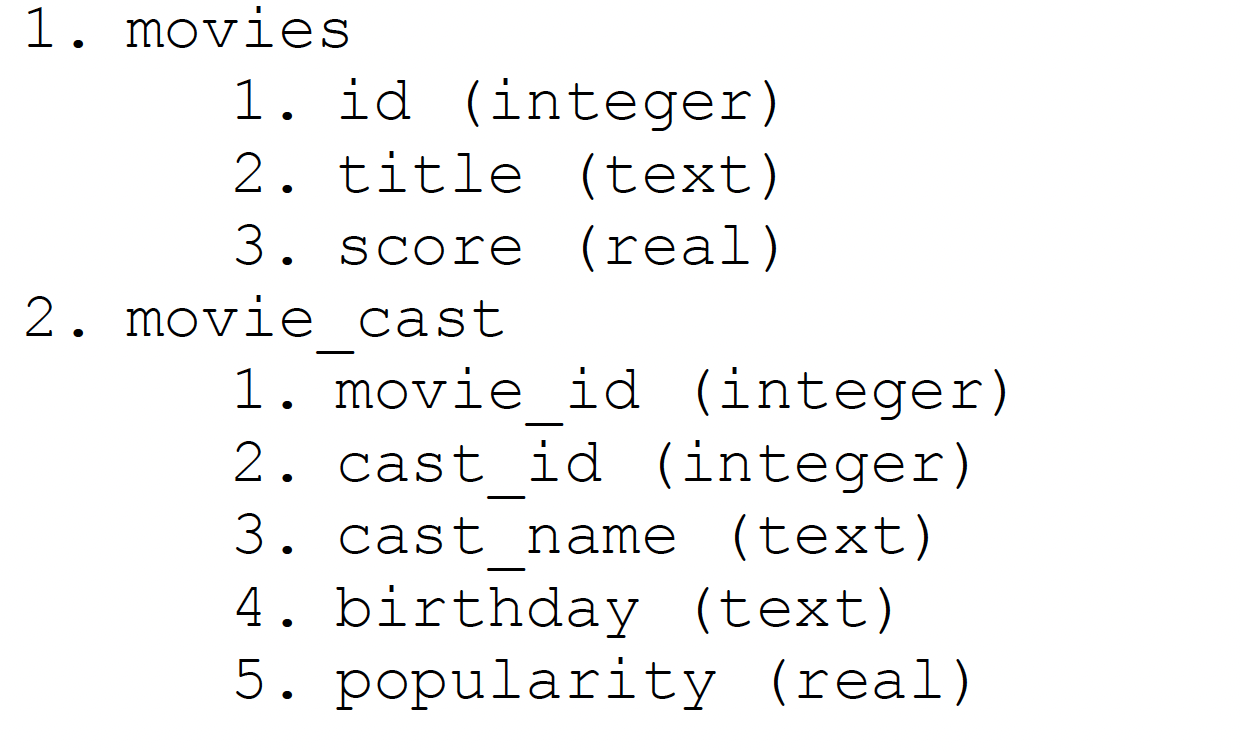

In [36]:
sql = "SELECT * FROM movies LIMIT 1"
cursor = connection.execute(sql)
print(cursor.fetchall())

[(11, 'Star Wars', 76.496)]


In [39]:
sql = "SELECT * FROM movie_cast LIMIT 1"
cursor = connection.execute(sql)
print(cursor.fetchall())

[(11, 2, 'Mark Hamill', '9/25/51', 15.015)]


In [51]:
sql = """SELECT cast_id,cast_name,AVG(mv.score) as average_score FROM movies mv
    INNER JOIN movie_cast mc
    ON mv.id = mc.movie_id
    where mv.score > 25
    group by mc.cast_id
    HAVING count(mc.movie_id)>2
    ORDER BY average_score desc, mc.cast_name asc
    LIMIT 10
    """
cursor = connection.execute(sql)
print(cursor.fetchall())

[(47698, 'Denis Lawson', 57.555), (12248, 'Alec Guinness', 52.30199999999999), (3, 'Harrison Ford', 52.30199999999999), (4, 'Carrie Fisher', 50.3722), (2, 'Mark Hamill', 50.3722), (1023139, 'Adam Driver', 49.41166666666667), (1333, 'Andy Serkis', 49.41166666666667), (1399531, 'Billie Lourd', 49.41166666666667), (1315036, 'Daisy Ridley', 49.41166666666667), (93210, 'Domhnall Gleeson', 49.41166666666667)]


In [60]:
sql = """select cast_id, cast_name, avg(mv.score) over(partition by mc.cast_id) ,
count(mv.score) over(partition by mc.cast_id) as mv_count
from movies mv inner join movie_cast mc on mv.id= mc.movie_id
"""
cursor = connection.execute(sql)
print(cursor.fetchall())

OperationalError: no such column: average_score